<a href="https://colab.research.google.com/github/szertan/DATASCI112-Space-Thruster-Project/blob/main/STP_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3. ML Models



In this section, we will analyse three different machine learning algorithms to predict the thrust output of a given setup.

### 3.1 K-Means Regression

In [1]:
# import training and testing subsets into separate files. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
m_train = pd.read_csv('/content/drive/MyDrive/STP/metadata_train.csv')
m_test = pd.read_csv('/content/drive/MyDrive/STP/metadata_test.csv')

In [2]:
m_train
# we will use the following parameters to train our algorithms: 
# test_pressure, test_mode, cumulated_throughput, cumulated_on_time, cumulated_pulses, thrust_rms, mfr_avg

,uid,filename,test_id,sn,test_pressure,test_mode,vl1,vl2,vl3,anomalous,anomaly_code,cumulated_throughput,cumulated_on_time,cumulated_pulses,thrust_rms,mfr_avg
0,1,00001_001_SN01_24bars_ssf.csv,1,1,24.0,ssf,True,True,False,False,0.0,0.000000,0.000000,0.0,1.197942,1.476201e+03
1,2,00002_002_SN01_21bars_ssf.csv,2,1,21.0,ssf,True,True,False,False,0.0,0.451717,0.083333,1.0,1.036821,1.276309e+03
2,3,00003_003_SN01_18bars_ssf.csv,3,1,18.0,ssf,True,True,False,False,0.0,0.842268,0.166667,2.0,0.879668,1.086460e+03
3,4,00004_004_SN01_15bars_ssf.csv,4,1,15.0,ssf,True,True,False,False,0.0,1.174725,0.250000,3.0,0.734270,9.080451e+02
4,5,00005_005_SN01_12bars_ssf.csv,5,1,12.0,ssf,True,True,False,False,0.0,1.452586,0.333333,4.0,0.601292,7.420246e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,1264,01264_108_SN12_5bars_onmod.csv,108,12,5.0,onmod,False,False,False,False,0.0,15.088221,6.743203,20860.0,0.003333,4.185253e-19
1263,1265,01265_109_SN12_5bars_offmod.csv,109,12,5.0,offmod,False,False,False,False,0.0,15.088221,6.765689,21660.0,0.003324,5.650626e-18
1264,1266,01266_110_SN12_5bars_random_short.csv,110,12,5.0,random_short,False,False,False,False,0.0,15.088221,6.976800,22460.0,0.003351,5.077638e-18
1265,1267,01267_111_SN12_5bars_random_long.csv,111,12,5.0,random_long,False,False,False,False,0.0,15.088221,7.016875,22760.0,0.003326,5.211657e-18


For this setup, we will pick the following parameters for our prediction task: 

**test_pressure** = the pressure of the experimental setup (specifically at the inlet of the thruster).

**test_mode** = the testing mode of the thruster, each mode with its own contraints on the rest of the operational settings. 


**cumulated_throughput** = the total amount of fuel consumed throughout the course of the mission.

**cumulated_on_time** = the total runtime for the mission. 

**cumulated_pulses** = the total number of times the engine has been restarted through a pulsed injection. 

**thrust_rms** = thrust_rms is defined as the root-mean-square value of thrust. it is extracted by calculating this value individually for every single csv file attached to each row of the metadata dataset. 

**mfr_avg** = mfr_avg is defined as the average value of mass-flow-rate. it is extracted by calculating this value individually for every single csv file attached to each row of the metadata dataset. 

These values are chosen primarily because they all frequently appear in scientific literature focusing on the optimisation of space thrusters. 

The first machine learning algorithm we will be testing on this setup is the KNeighborsRegressor model. We will then plot the error rates for the KNeighborsRegressor model based on different values of $k$.

Text(0.5, 0, 'k')

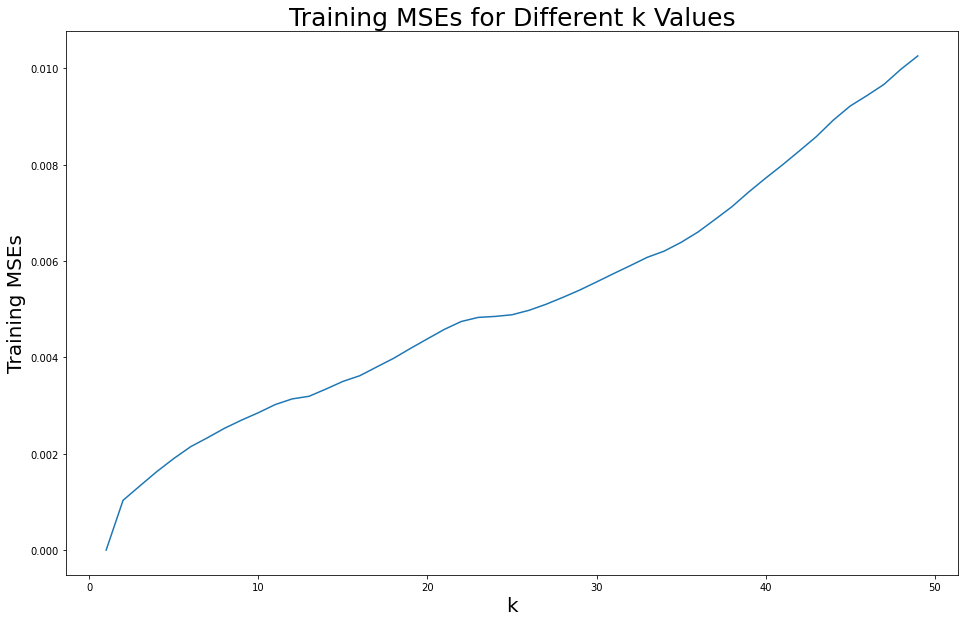

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

X_train = m_train[["test_pressure", "test_mode", "cumulated_throughput", "cumulated_on_time", "cumulated_pulses", "mfr_avg"]]
y_train = m_train["thrust_rms"]
X_test = m_test[["test_pressure", "test_mode", "cumulated_throughput", "cumulated_on_time", "cumulated_pulses", "mfr_avg"]]
y_test = m_test["thrust_rms"]

ks, training_mses = range(1, 50), []
for k in ks:
  pipeline_kmeans = make_pipeline(
      make_column_transformer(
          (OneHotEncoder(), ["test_mode"]),
          remainder="passthrough"),
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k, metric="euclidean"))
  pipeline_kmeans.fit(X_train, y_train)
  y_train_ = pipeline_kmeans.predict(X_train)  # the trailing underscore is the equivalent of "hat", indicates fitted value
  training_mses.append(mean_squared_error(y_train, y_train_))
                                          
pd.Series(training_mses, index=ks).plot.line()
fig = plt.gcf()
fig.set_size_inches(16,10)
plt.title("Training MSEs for Different k Values", size=25)
ax = plt.gca()
ax.set_ylabel("Training MSEs", size = 20)
ax.set_xlabel("k", size = 20)

Now, we will also calculate the Training MSEs for the cross validation set and find the value of $k$ for which it is smallest. 

4     0.004270
3     0.004309
6     0.004327
5     0.004337
7     0.004401
8     0.004449
2     0.004465
9     0.004523
10    0.004629
11    0.004646
12    0.004690
13    0.004770
14    0.004899
15    0.004991
16    0.005160
17    0.005327
1     0.005438
18    0.005523
19    0.005677
20    0.005803
21    0.005899
22    0.005925
23    0.005974
24    0.006065
25    0.006209
26    0.006380
27    0.006538
28    0.006728
29    0.006891
30    0.007092
31    0.007306
32    0.007541
33    0.007787
34    0.008089
35    0.008375
36    0.008708
37    0.008999
38    0.009328
39    0.009653
40    0.009999
41    0.010298
42    0.010580
43    0.010856
44    0.011175
45    0.011477
46    0.011772
47    0.012074
48    0.012387
49    0.012744
dtype: float64

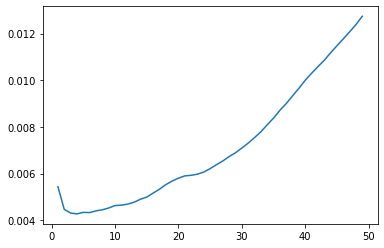

In [4]:
from sklearn.model_selection import cross_val_score

ks, val_mses = range(1, 50), []
for k in ks:
  pipeline = make_pipeline(
      make_column_transformer(
          (OneHotEncoder(), ["test_mode"]),
          remainder="passthrough"),
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k, metric="euclidean"))
  val_mses.append(-cross_val_score(
      pipeline,
      X_train, y_train,
      scoring="neg_mean_squared_error",
      cv=10).mean())

val_mses = pd.Series(val_mses, index=ks)
val_mses.plot.line()
val_mses.sort_values()

<Axes: >

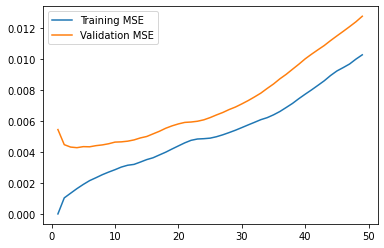

In [5]:
pd.DataFrame({
    "Training MSE": training_mses,
    "Validation MSE": val_mses
}).plot.line(legend=True)

Hence, it has been found that $k = 4$ performs the best for this case. MSE for the validation set is found to be 0.004270.

Now, we will test the model on the testing set with the optimal parameter $k = 4$ fed into the model. 

In [6]:
optimal_pipeline_kmeans = make_pipeline(
      make_column_transformer(
          (OneHotEncoder(), ["test_mode"]),
          remainder="passthrough"),
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=4, metric="euclidean"))

optimal_pipeline_kmeans.fit(X_train, y_train)
y_test_ = optimal_pipeline_kmeans.predict(X_test)  # the trailing underscore is the equivalent of "hat", indicates fitted value
print(mean_squared_error(y_test, y_test_))

0.007548096467346429


Thus, MSE for the test set is found to be 0.007549.


### 3.2 Linear Regression


In our second model, we will test a linear regression model on the same dataset and parameters to compare with our first model. 

In [7]:
from sklearn.linear_model import LinearRegression

pipeline_linear = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), ["test_mode"]),
        remainder="passthrough"),
    StandardScaler(),
    LinearRegression())

pipeline_linear.fit(X_train, y_train)
y_train_linear_ = pipeline_linear.predict(X_train)  # the trailing underscore is the equivalent of "hat", indicates fitted value
print(mean_squared_error(y_train, y_train_linear_))

0.0032949527598497494


Thus, MSE for the validation set is found to be 0.003295. We now run the model on the test set:

In [8]:
y_test_ = pipeline_linear.predict(X_test)  # the trailing underscore is the equivalent of "hat", indicates fitted value
print(mean_squared_error(y_test, y_test_))

0.0019530762734280356


As such, MSE for the test set is found to be 0.001954.

### 3.3 Neural Network Regressor


As our third and last model, we will be training a neural network to compare its performance for our prediction to the previous two models. We will also apply hyperparameter tuning techniques on this model to advance it even further. 

In [9]:
# hyperparameter tuning: 
# num_hidden: depth of the hidden layers (total layers = num_hidden + 2)
# num_neurons: number of neurons per layer

from sklearn.neural_network import MLPRegressor
import numpy as np

num_hidden_array = [2, 3, 4, 5, 6]
num_neuron_array = [16, 32, 64, 128]
validation_mses = np.zeros((len(num_hidden_array), len(num_neuron_array)))

for id_hidden in range(len(num_hidden_array)):
  num_hidden = num_hidden_array[id_hidden]
  for id_neuron in range(len(num_neuron_array)):
    num_neuron = num_neuron_array[id_neuron]
    pipeline_neural = make_pipeline(
        make_column_transformer(
            (OneHotEncoder(), ["test_mode"]),
            remainder="passthrough"),
        StandardScaler(),
        MLPRegressor([num_neuron for i in range(num_hidden)]))
    pipeline_neural.fit(X_train, y_train)

    mse = -cross_val_score(
        pipeline_neural,
        X_train, y_train,
        scoring="neg_mean_squared_error",
        cv=10).mean()

    print(f'num_hidden={num_hidden}, num_neuron={num_neuron}, val_MSE={mse}')
    validation_mses[id_hidden, id_neuron] = mse

num_hidden=2, num_neuron=16, val_MSE=0.006072122045247192
num_hidden=2, num_neuron=32, val_MSE=0.003829276495973115
num_hidden=2, num_neuron=64, val_MSE=0.003199399738973519
num_hidden=2, num_neuron=128, val_MSE=0.004009600050508685
num_hidden=3, num_neuron=16, val_MSE=0.005469082365357506
num_hidden=3, num_neuron=32, val_MSE=0.006228999193588389
num_hidden=3, num_neuron=64, val_MSE=0.003602980828720217
num_hidden=3, num_neuron=128, val_MSE=0.0039816423551627565
num_hidden=4, num_neuron=16, val_MSE=0.005060736612918662
num_hidden=4, num_neuron=32, val_MSE=0.0051770791964586595
num_hidden=4, num_neuron=64, val_MSE=0.003828968765384899
num_hidden=4, num_neuron=128, val_MSE=0.004792590536358369
num_hidden=5, num_neuron=16, val_MSE=0.004128739461874082
num_hidden=5, num_neuron=32, val_MSE=0.004139538934333017
num_hidden=5, num_neuron=64, val_MSE=0.003853784014075107
num_hidden=5, num_neuron=128, val_MSE=0.004549392878410959
num_hidden=6, num_neuron=16, val_MSE=0.004553682255227759
num_hidd

In [10]:
optimal_hyperparam_id = np.argwhere(validation_mses == np.min(validation_mses))
optimal_num_hidden = num_hidden_array[int(optimal_hyperparam_id[0,0])]
optimal_num_neuron = num_neuron_array[int(optimal_hyperparam_id[0,1])]
print('Optimal Hidden Layers:', optimal_num_hidden)
print('Optimal Neurons per Layer:', optimal_num_neuron)
print('Optimal Validation MSE', np.min(validation_mses))

Optimal Hidden Layers: 2
Optimal Neurons per Layer: 64
Optimal Validation MSE 0.003199399738973519


We have thus found the optimal number of hidden layers to be 4, optimal number of neurons per layer to be 128, and MSE over the validation set to be 0.004122.


In [11]:
optimal_pipeline_neural = make_pipeline(
      make_column_transformer(
          (OneHotEncoder(), ["test_mode"]),
          remainder="passthrough"),
      StandardScaler(),
      MLPRegressor([optimal_num_neuron for i in range(optimal_num_hidden)]))
optimal_pipeline_neural.fit(X_train, y_train)
y_test_ = optimal_pipeline_neural.predict(X_test)  # the trailing underscore is the equivalent of "hat", indicates fitted value
print(mean_squared_error(y_test, y_test_))

0.005509578697064578


Finally, MSE for the test set is found to be .004118.


### 3.4 Results

Comparing the three machine learning models to predict the thrust output for our space thrusters, we have the following: 

### **K-Means Regression:**
*Optimal K-Means: $k = 4$.*

*Validation MSE = 0.004270.*

*Test MSE = 0.007549.*

### **Linear Regression:**

*Test MSE is = 0.001953*

*Validation MSE = 0.004270.*

### **Neural Network:**
*Optimal Test MSE = 0.004117.*

*Optimal Validation MSE = 0.004122.*

*Optimal Hidden Layers: 4.*

*Optimal Neurons per Layer: 128.*

### 3.5 Conclusion

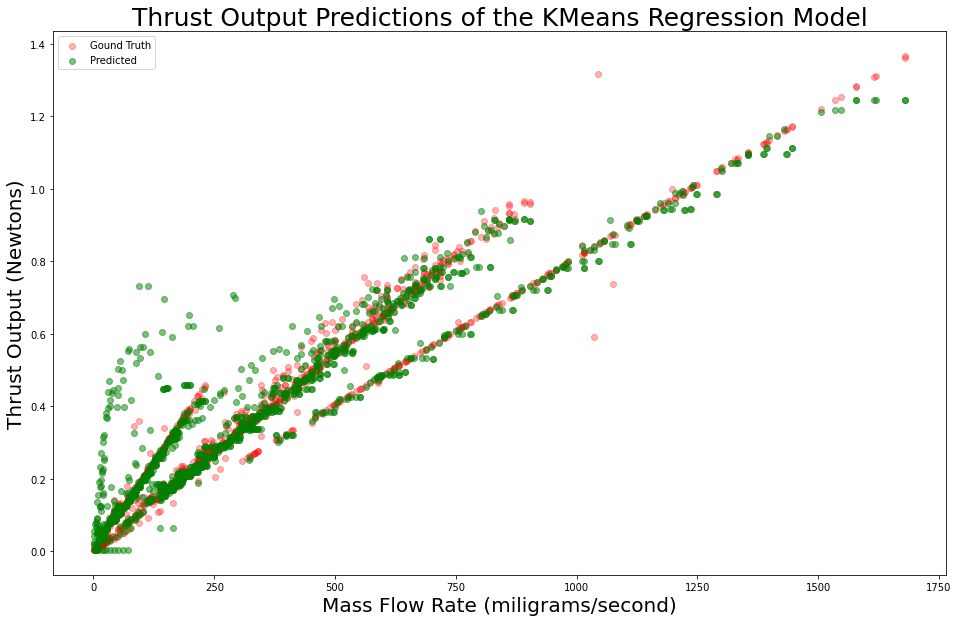

In [18]:
m_test["thrust_pre_k"] = optimal_pipeline_kmeans.predict(X_test)
plt.scatter(m_test["mfr_avg"], m_test["thrust_rms"], alpha=0.30, color='red', label='Gound Truth')
plt.scatter(m_test["mfr_avg"], m_test["thrust_pre_k"], alpha=0.50, color='green', label='Predicted')
fig = plt.gcf()
fig.set_size_inches(16,10)
plt.title("Thrust Output Predictions of the KMeans Regression Model", size=25)
ax = plt.gca()
ax.set_ylabel("Thrust Output (Newtons)", size = 20)
ax.set_xlabel("Mass Flow Rate (miligrams/second)", size = 20)
plt.legend()

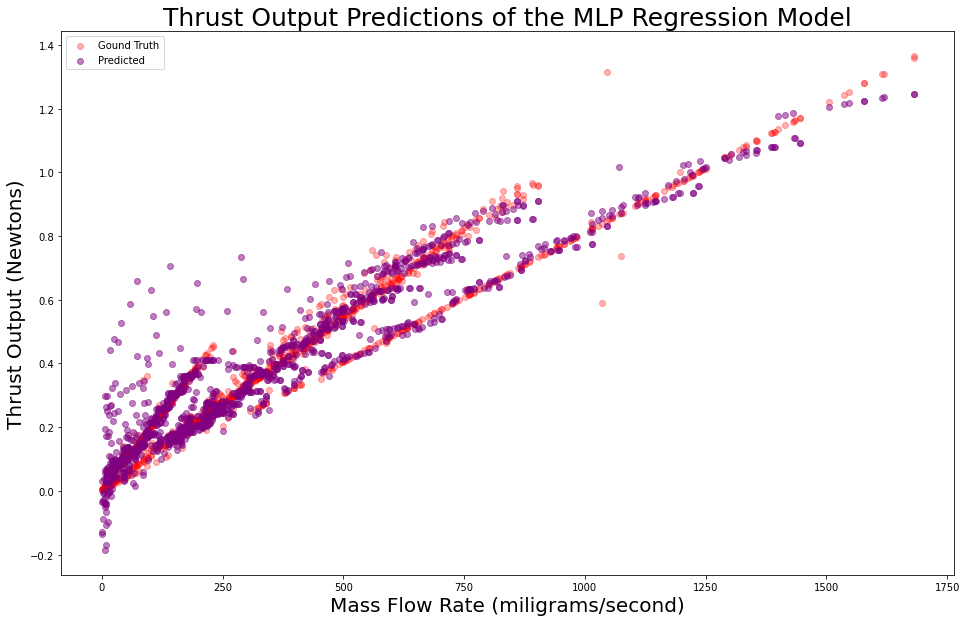

In [20]:
m_test["thrust_pre_n"] = optimal_pipeline_neural.predict(X_test)
plt.scatter(m_test["mfr_avg"], m_test["thrust_rms"], alpha=0.30, color='red', label='Gound Truth')
plt.scatter(m_test["mfr_avg"], m_test["thrust_pre_n"], alpha=0.50, color='purple', label='Predicted')
fig = plt.gcf()
fig.set_size_inches(16,10)
plt.title("Thrust Output Predictions of the MLP Regression Model", size=25)
ax = plt.gca()
ax.set_ylabel("Thrust Output (Newtons)", size = 20)
ax.set_xlabel("Mass Flow Rate (miligrams/second)", size = 20)
plt.legend()

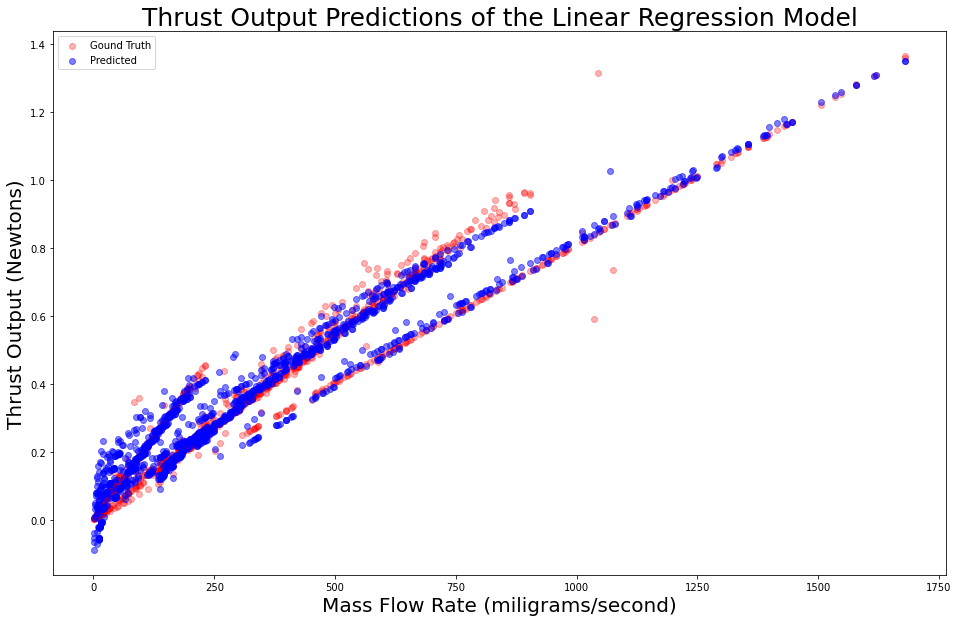

In [21]:
m_test["thrust_pre"] = pipeline_linear.predict(X_test)
plt.scatter(m_test["mfr_avg"], m_test["thrust_rms"], alpha=0.30, color='red', label='Gound Truth')
plt.scatter(m_test["mfr_avg"], m_test["thrust_pre"], alpha=0.50, color='blue', label='Predicted')
fig = plt.gcf()
fig.set_size_inches(16,10)
plt.title("Thrust Output Predictions of the Linear Regression Model", size=25)
ax = plt.gca()
ax.set_ylabel("Thrust Output (Newtons)", size = 20)
ax.set_xlabel("Mass Flow Rate (miligrams/second)", size = 20)
plt.legend()

At the end of this project, we have shown that the linear regression model is capable of all three of the trends we had initially observed in our training set once evaluated on the test set. The algorithm should prove to be useful in a few cases: 

1. Assume we are to design a space thruster from scratch, and we are to try a setup that no one has ever used before. So long as we have access to a facility with the information regarding the parameters we have fed into the algorithm available at hand (all which are easy to access to compared to conducting a thrust measurement), we would be able to predict the thrust output reliably, without spending anything from our very much scarce research funding. We would then be able to invest our resources into the setups that would bring the highest expected yields. 

2. Assume that we have decided on a specific facility / propulsion setup to use for our research, but we are unsure whether we would be able to scale this product for industrial usage to deliver thrust outputs at specific ranges. Then, once again, we can feed multiple scenarios regarding the setup's operating conditions, and observe which settings yield to the desired growth rates for our needs. This would allow us to have a reliable basis to ensure that we would be increasing the output as rapidly as we need. 

*(Scalability of any space thruster poses a major problem for any given setup since the trends seldom behave as expected, as we have seen from the analysis we conducted in this project. We might be able to get our desired thrust output for a prototype, but as it may be seen in the graph above, the same thrust outputs may have considerably different growth rates. Thus, knowing whether or not a prototype may be scaled proves to be a very, very valuable piece of information in evaluating the operational value of a setup. This project serves a starting point in understanding a relationship we do not know how to think about yet.)*

For the future of this project, I am aiming to develop a clustering model to identify the growth regimes as different clusters. By doing so, we could predict which trend a given case would fall into without having to rely on external datapoints to compare our case. Both KMeans Clustering and Agglomerative Clustering failed miserably for this setup, and the development of an accurate clustering methodology would be the next step for the project.
